In [1]:
import tensorflow as tf
print(tf.__version__)

!pip install lightgbm
!pip install scikit-learn
!pip install xgboost
!pip install imbalanced-learn
!pip install shap

import pandas as pd
import numpy as np
import wfdb
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


2.19.0


In [2]:
#Import Phase-Folded Dataset
df1 = pd.read_csv('pqrst_intervals.csv')


In [4]:
#Import PTB-XL Dataset
path = 'C:/ECG Project/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 500

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [5]:
# Aggregate diagnostic superclass from scp_codes
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [6]:
# Load diagnostic categories (from scp_statements.csv)
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [7]:
# Apply diagnostic superclass to the annotation data
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [8]:
# Merge the PQRST features with the labels (diagnostic_superclass and strat_fold)
merged_df = df1.merge(Y[['age','sex','diagnostic_superclass', 'strat_fold']], on='ecg_id', how='left')
merged_df.to_csv('pqrst_superclass.csv', index=False)
merged_df.head

<bound method NDFrame.head of        ecg_id  P onset  P Peak      Q      R      S  T onset  T peak  T end  \
0           1    196.0   260.0  342.0  376.0  484.0    550.0   656.0    NaN   
1           2    322.0   364.0  476.0  508.0  536.0    588.0   784.0  890.0   
2           3    206.0   242.0  332.0  374.0  406.0    560.0   674.0    NaN   
3           4    142.0   184.0  284.0  316.0  346.0    398.0   544.0    NaN   
4           5    172.0   238.0  328.0  362.0  420.0    494.0   624.0  712.0   
...       ...      ...     ...    ...    ...    ...      ...     ...    ...   
20663   21832     96.0   142.0  202.0  278.0  510.0      NaN     NaN    NaN   
20664   21833     42.0    78.0  194.0  222.0  258.0    314.0   326.0  412.0   
20665   21834    164.0   236.0  324.0  356.0  392.0    444.0   626.0    NaN   
20666   21835    236.0   294.0  382.0  412.0  500.0    602.0   720.0    NaN   
20667   21837    186.0   246.0  364.0  406.0  468.0    522.0   666.0  758.0   

       QRS Duration (

In [9]:
# Split the data into train and test based on the stratified fold
test_fold = 10

# Training set (excluding fold 10)
train_df = merged_df[merged_df.strat_fold != test_fold]
X_train = train_df.drop(columns=['ecg_id', 'diagnostic_superclass', 'strat_fold'])  # Features
y_train = train_df['diagnostic_superclass']  # Labels

In [10]:
X_train.columns

Index(['P onset', 'P Peak', 'Q', 'R', 'S', 'T onset', 'T peak', 'T end',
       'QRS Duration (ms)', 'PR Interval (ms)', 'ST Interval (ms)',
       'P Amplitude', 'Q Amplitude', 'R Amplitude', 'S Amplitude',
       'T Amplitude', 'Average RR (ms)', 'Heart Rate (bpm)', 'age', 'sex'],
      dtype='object')

In [11]:
#Checking empty entries in y_train
empty_entries = y_train.apply(lambda x: len(x) == 0)
empty_entries.sum()

241

In [12]:
#Checking NaN 
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in X_train:", X_train.isna().sum())

NaNs in y_train: 0
NaNs in X_train: P onset                  0
P Peak                   0
Q                        0
R                        0
S                        0
T onset                228
T peak                1235
T end                12270
QRS Duration (ms)        0
PR Interval (ms)         0
ST Interval (ms)      1235
P Amplitude              0
Q Amplitude              0
R Amplitude              0
S Amplitude              0
T Amplitude           1235
Average RR (ms)          0
Heart Rate (bpm)         0
age                      0
sex                      0
dtype: int64


In [13]:
# Keep only rows where diagnostic_superclass is not empty
valid_mask = y_train.apply(lambda x: isinstance(x, list) and len(x) > 0)
X_train = X_train[valid_mask]
y_train = y_train[valid_mask]
# Now convert multi-label lists to just the first label
y_train = y_train.apply(lambda x: x[0])


In [14]:
#Checking NaN, y_train is clear
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in X_train:", X_train.isna().sum())

NaNs in y_train: 0
NaNs in X_train: P onset                  0
P Peak                   0
Q                        0
R                        0
S                        0
T onset                223
T peak                1190
T end                12089
QRS Duration (ms)        0
PR Interval (ms)         0
ST Interval (ms)      1190
P Amplitude              0
Q Amplitude              0
R Amplitude              0
S Amplitude              0
T Amplitude           1190
Average RR (ms)          0
Heart Rate (bpm)         0
age                      0
sex                      0
dtype: int64


In [15]:
#Drop T end, too many NaN
X_train = X_train.drop(columns=["T end"])


In [16]:
#Checking NaN, less than before
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in X_train:", X_train.isna().sum())

NaNs in y_train: 0
NaNs in X_train: P onset                 0
P Peak                  0
Q                       0
R                       0
S                       0
T onset               223
T peak               1190
QRS Duration (ms)       0
PR Interval (ms)        0
ST Interval (ms)     1190
P Amplitude             0
Q Amplitude             0
R Amplitude             0
S Amplitude             0
T Amplitude          1190
Average RR (ms)         0
Heart Rate (bpm)        0
age                     0
sex                     0
dtype: int64


In [17]:
# Testing set (only fold 10)
test_df = merged_df[merged_df.strat_fold == test_fold]
X_test = test_df.drop(columns=['ecg_id', 'diagnostic_superclass', 'strat_fold'])  # Features
y_test = test_df['diagnostic_superclass']  # Labels

#Checking NaN
print("NaNs in y_test:", y_test.isna().sum())
print("NaNs in X_test:", X_test.isna().sum())


NaNs in y_test: 0
NaNs in X_test: P onset                 0
P Peak                  0
Q                       0
R                       0
S                       0
T onset                25
T peak                126
T end                1355
QRS Duration (ms)       0
PR Interval (ms)        0
ST Interval (ms)      126
P Amplitude             0
Q Amplitude             0
R Amplitude             0
S Amplitude             0
T Amplitude           126
Average RR (ms)         0
Heart Rate (bpm)        0
age                     0
sex                     0
dtype: int64


In [18]:
#Same steps with test data
valid_mask_test = y_test.apply(lambda x: isinstance(x, list) and len(x) > 0)
X_test = X_test[valid_mask_test]
y_test = y_test[valid_mask_test]
y_test = y_test.apply(lambda x: x[0])

#Drop T end in Test data
X_test = X_test.drop(columns=["T end"])


In [19]:
#Checking NaN
print("NaNs in y_test:", y_test.isna().sum())
print("NaNs in X_test:", X_test.isna().sum())

NaNs in y_test: 0
NaNs in X_test: P onset                0
P Peak                 0
Q                      0
R                      0
S                      0
T onset               25
T peak               125
QRS Duration (ms)      0
PR Interval (ms)       0
ST Interval (ms)     125
P Amplitude            0
Q Amplitude            0
R Amplitude            0
S Amplitude            0
T Amplitude          125
Average RR (ms)        0
Heart Rate (bpm)       0
age                    0
sex                    0
dtype: int64


In [20]:
from sklearn.impute import KNNImputer

#columns with missing values
columns_to_impute = ['T onset', 'T peak', 'T Amplitude']

#KNN imputer
imputer = KNNImputer(n_neighbors=5) 

# Fit on X_train and transform
X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])

#same imputer to transform X_test
X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])


In [21]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())


P onset                 0
P Peak                  0
Q                       0
R                       0
S                       0
T onset                 0
T peak                  0
QRS Duration (ms)       0
PR Interval (ms)        0
ST Interval (ms)     1190
P Amplitude             0
Q Amplitude             0
R Amplitude             0
S Amplitude             0
T Amplitude             0
Average RR (ms)         0
Heart Rate (bpm)        0
age                     0
sex                     0
dtype: int64
P onset                0
P Peak                 0
Q                      0
R                      0
S                      0
T onset                0
T peak                 0
QRS Duration (ms)      0
PR Interval (ms)       0
ST Interval (ms)     125
P Amplitude            0
Q Amplitude            0
R Amplitude            0
S Amplitude            0
T Amplitude            0
Average RR (ms)        0
Heart Rate (bpm)       0
age                    0
sex                    0
dtype: int64


In [22]:
#Fixing ST Segment, not imputed with knn - used S and T values for better accuracy
X_train['ST Interval (ms)'] = X_train['T onset'] - X_train['S']
X_test['ST Interval (ms)'] = X_test['T onset'] - X_test['S']


In [23]:
#Checking NaN, all clear
print(X_train.isnull().sum())
print(X_test.isnull().sum())

P onset              0
P Peak               0
Q                    0
R                    0
S                    0
T onset              0
T peak               0
QRS Duration (ms)    0
PR Interval (ms)     0
ST Interval (ms)     0
P Amplitude          0
Q Amplitude          0
R Amplitude          0
S Amplitude          0
T Amplitude          0
Average RR (ms)      0
Heart Rate (bpm)     0
age                  0
sex                  0
dtype: int64
P onset              0
P Peak               0
Q                    0
R                    0
S                    0
T onset              0
T peak               0
QRS Duration (ms)    0
PR Interval (ms)     0
ST Interval (ms)     0
P Amplitude          0
Q Amplitude          0
R Amplitude          0
S Amplitude          0
T Amplitude          0
Average RR (ms)      0
Heart Rate (bpm)     0
age                  0
sex                  0
dtype: int64


In [24]:
# 1. Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 2. Predict on Test Set
y_pred = clf.predict(X_test)

# 3. Evaluate Performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 23   4  39  83   5]
 [  5  41  62  50  15]
 [ 12  31 252 155  42]
 [ 11   4  35 890  17]
 [  3   7 120  71  71]]

Classification Report:
              precision    recall  f1-score   support

          CD       0.43      0.15      0.22       154
         HYP       0.47      0.24      0.32       173
          MI       0.50      0.51      0.50       492
        NORM       0.71      0.93      0.81       957
        STTC       0.47      0.26      0.34       272

    accuracy                           0.62      2048
   macro avg       0.52      0.42      0.44      2048
weighted avg       0.59      0.62      0.59      2048



In [25]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define the model
model = LGBMClassifier(
    boosting_type='gbdt',     # Gradient Boosting Decision Trees
    objective='multiclass',   # multiple classes (CD, HYP, MI, NORM, STTC)
    num_class=len(np.unique(y_train)), # Number of classes
    random_state=42,
)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3997
[LightGBM] [Info] Number of data points in the train set: 18357, number of used features: 19
[LightGBM] [Info] Start training from score -2.630865
[LightGBM] [Info] Start training from score -2.443764
[LightGBM] [Info] Start training from score -1.424324
[LightGBM] [Info] Start training from score -0.769710
[LightGBM] [Info] Start training from score -1.985355
              precision    recall  f1-score   support

          CD       0.45      0.21      0.28       154
         HYP       0.44      0.29      0.35       173
          MI       0.52      0.47      0.49       492
        NORM       0.72      0.92      0.81       957
        STTC       0.50   

In [26]:
# Ratios of Amplitudes
X_train['R_to_S_ratio'] = X_train['R Amplitude'] / (X_train['S Amplitude'] + 1e-6)
X_train['P_to_R_ratio'] = X_train['P Amplitude'] / (X_train['R Amplitude'] + 1e-6)
X_train['T_to_R_ratio'] = X_train['T Amplitude'] / (X_train['R Amplitude'] + 1e-6)

X_test['R_to_S_ratio'] = X_test['R Amplitude'] / (X_test['S Amplitude'] + 1e-6)
X_test['P_to_R_ratio'] = X_test['P Amplitude'] / (X_test['R Amplitude'] + 1e-6)
X_test['T_to_R_ratio'] = X_test['T Amplitude'] / (X_test['R Amplitude'] + 1e-6)

# Composite Durations (Multiplying two features)
X_train['PRxQRS'] = X_train['PR Interval (ms)'] * X_train['QRS Duration (ms)']
X_train['QRSxST'] = X_train['QRS Duration (ms)'] * X_train['ST Interval (ms)']

X_test['PRxQRS'] = X_test['PR Interval (ms)'] * X_test['QRS Duration (ms)']
X_test['QRSxST'] = X_test['QRS Duration (ms)'] * X_test['ST Interval (ms)']

# Absolute Differences
X_train['Q_R_diff'] = X_train['R'] - X_train['Q']
X_train['S_T_diff'] = X_train['T onset'] - X_train['S']

X_test['Q_R_diff'] = X_test['R'] - X_test['Q']
X_test['S_T_diff'] = X_test['T onset'] - X_test['S']


In [72]:
# Duration from P onset to T onset (P to T onset interval)
X_train['P_Tonset_interval'] = (X_train['T onset'] - X_train['P onset']) / 500
X_test['P_Tonset_interval'] = (X_test['T onset'] - X_test['P onset']) / 500

# P onset to S
X_train['P_to_S_duration'] = (X_train['S'] - X_train['P onset']) / 500
X_test['P_to_S_duration'] = (X_test['S'] - X_test['P onset']) / 500

# R Amplitude minus S Amplitude
X_train['R_minus_S_amp'] = X_train['R Amplitude'] - X_train['S Amplitude']
X_test['R_minus_S_amp'] = X_test['R Amplitude'] - X_test['S Amplitude']

# ST/HR interaction 
X_train['STxHR'] = X_train['ST Interval (ms)'] * X_train['Heart Rate (bpm)']
X_test['STxHR'] = X_test['ST Interval (ms)'] * X_test['Heart Rate (bpm)']

In [74]:
X_train.columns

Index(['P onset', 'P Peak', 'Q', 'R', 'S', 'T onset', 'T peak',
       'QRS Duration (ms)', 'PR Interval (ms)', 'ST Interval (ms)',
       'P Amplitude', 'Q Amplitude', 'R Amplitude', 'S Amplitude',
       'T Amplitude', 'Average RR (ms)', 'Heart Rate (bpm)', 'age', 'sex',
       'R_to_S_ratio', 'P_to_R_ratio', 'T_to_R_ratio', 'PRxQRS', 'QRSxST',
       'Q_R_diff', 'S_T_diff', 'P_Tonset_interval', 'P_to_S_duration',
       'R_minus_S_amp', 'Q_to_S_interval', 'PR_over_QRS', 'STxHR',
       'QRS_vs_PT_amp'],
      dtype='object')

In [29]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define and train the model after feature engineering
model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',  # For multiclass classification
    num_class=len(np.unique(y_train)),  # Number of classes
    random_state=42,
)

# Train the model with updated features
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7166
[LightGBM] [Info] Number of data points in the train set: 18357, number of used features: 33
[LightGBM] [Info] Start training from score -2.630865
[LightGBM] [Info] Start training from score -2.443764
[LightGBM] [Info] Start training from score -1.424324
[LightGBM] [Info] Start training from score -0.769710
[LightGBM] [Info] Start training from score -1.985355
              precision    recall  f1-score   support

          CD       0.50      0.27      0.35       154
         HYP       0.41      0.23      0.30       173
          MI       0.52      0.49      0.51       492
        NORM       0.73      0.92      0.81       957
        STTC       0.49      0.35      0.41       272

    accuracy                       

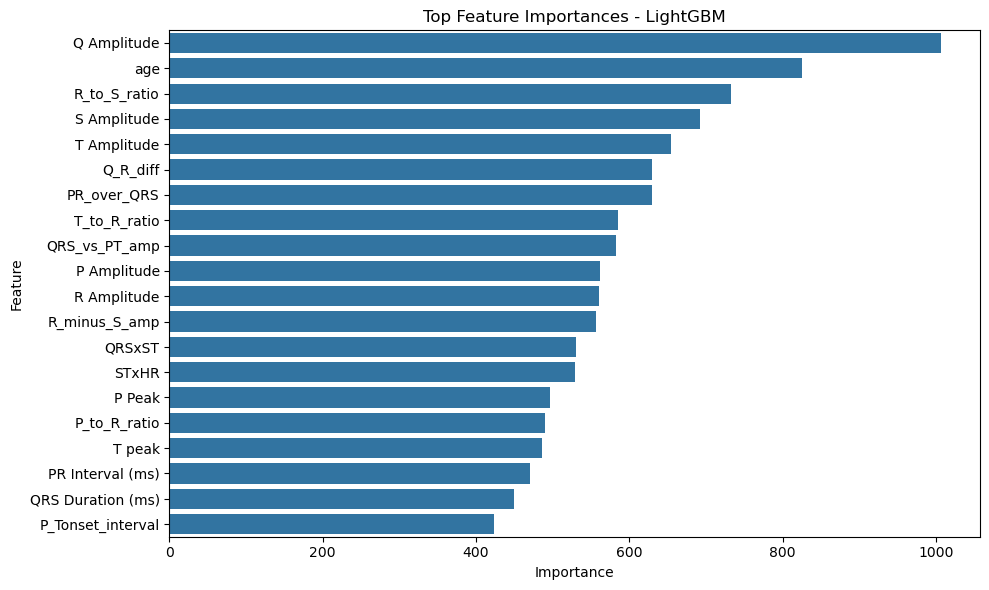

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Combine into a DataFrame for sorting and plotting
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(20))  # Top 20
plt.title('Top Feature Importances - LightGBM')
plt.tight_layout()
plt.show()


In [32]:
# Combine features
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# Combine labels
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7165
[LightGBM] [Info] Number of data points in the train set: 18364, number of used features: 33
[LightGBM] [Info] Start training from score -2.626718
[LightGBM] [Info] Start training from score -2.446029
[LightGBM] [Info] Start training from score -1.424479
[LightGBM] [Info] Start training from score -0.768798
[LightGBM] [Info] Start training from score -1.988915
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7165
[LightGBM] [Info] Number of data points in the train set: 18364, number of used featu

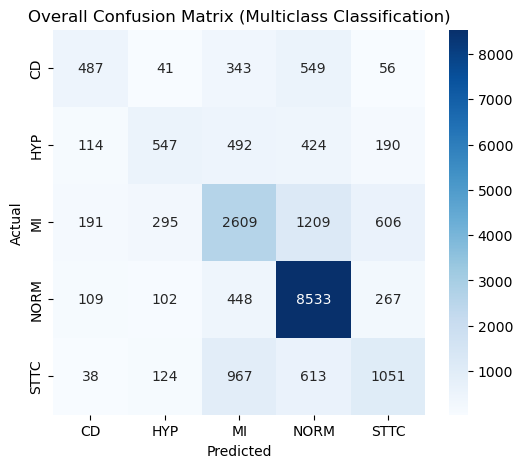


Confusion Matrix (%):
[[32.99  2.78 23.24 37.2   3.79]
 [ 6.45 30.96 27.84 24.   10.75]
 [ 3.89  6.01 53.14 24.62 12.34]
 [ 1.15  1.08  4.74 90.21  2.82]
 [ 1.36  4.44 34.62 21.95 37.63]]


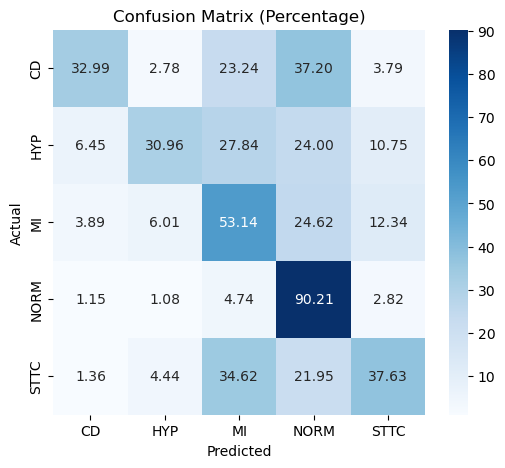


Classification Report (Overall):
              precision    recall  f1-score   support

          CD       0.52      0.33      0.40      1476
         HYP       0.49      0.31      0.38      1767
          MI       0.54      0.53      0.53      4910
        NORM       0.75      0.90      0.82      9459
        STTC       0.48      0.38      0.42      2793

    accuracy                           0.65     20405
   macro avg       0.56      0.49      0.51     20405
weighted avg       0.62      0.65      0.63     20405



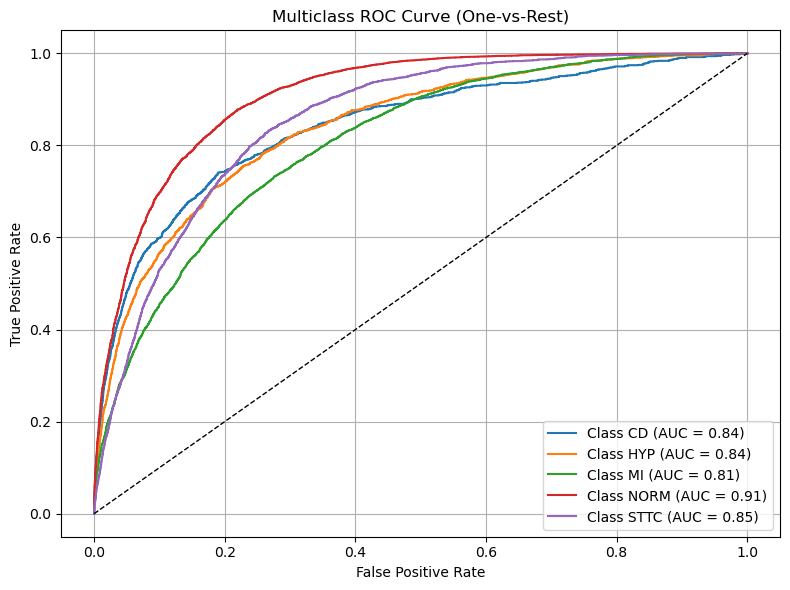

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

# Define classes
classes = np.unique(y)
n_classes = len(classes)

# Stratified Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model = LGBMClassifier(objective='multiclass', num_class=n_classes, random_state=42)

accuracies = []
all_preds = []
all_true = []
all_probs = []

# Perform 10-fold CV
for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    y_proba = model.predict_proba(X_val_fold)

    accuracies.append(accuracy_score(y_val_fold, y_pred))
    all_true.extend(y_val_fold)
    all_preds.extend(y_pred)
    all_probs.append(y_proba)

# Average accuracy
print(f"\nAverage accuracy: {np.mean(accuracies):.4f}")

# Confusion Matrix (Overall)
cm = confusion_matrix(all_true, all_preds)
print("\nOverall Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("CM 1.png", dpi=300, bbox_inches='tight')
plt.title('Overall Confusion Matrix (Multiclass Classification)')
plt.show()

# Normalize the confusion matrix row-wise (by true class)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Print numeric version (rounded)
print("\nConfusion Matrix (%):")
print(np.round(cm_percentage, 2))

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.savefig("CM_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report (Overall):")
print(classification_report(all_true, all_preds))

report_dict = classification_report(all_true, all_preds, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose().round(2)


# ROC Curve
from itertools import cycle

# Stack predictions and binarize true labels
all_probs = np.vstack(all_probs)
y_true_bin = label_binarize(all_true, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(plt.cm.tab10.colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC 1.png", dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# Create a binary classification target
y_train_binary = y_train.apply(lambda x: 1 if 'NORM' not in x else 0)
y_test_binary = y_test.apply(lambda x: 1 if 'NORM' not in x else 0)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8870, number of negative: 7651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7138
[LightGBM] [Info] Number of data points in the train set: 16521, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536892 -> initscore=0.147838
[LightGBM] [Info] Start training from score 0.147838
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8870, number of negative: 7651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 16521, number of used featu

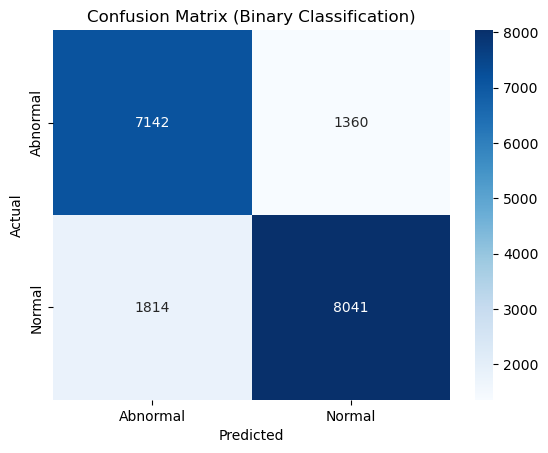


Confusion Matrix (%):
[[84.   16.  ]
 [18.41 81.59]]


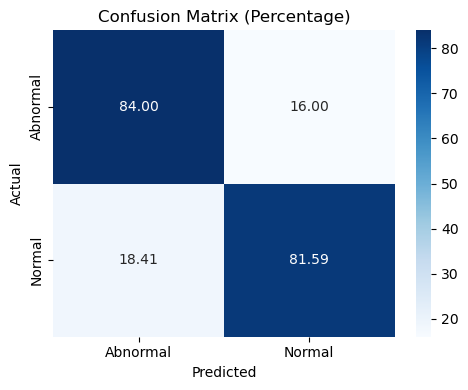


Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.80      0.84      0.82      8502
      Normal       0.86      0.82      0.84      9855

    accuracy                           0.83     18357
   macro avg       0.83      0.83      0.83     18357
weighted avg       0.83      0.83      0.83     18357

AUC-ROC Score: 0.9076
F1 Macro Score: 0.8267


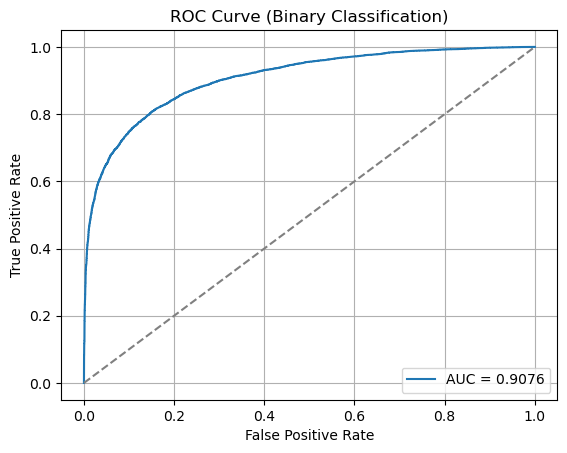

In [35]:
# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
all_preds = []
all_probs = []
all_true = []

# K-Fold Loop
for train_index, val_index in skf.split(X_train, y_train_binary):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train_binary.iloc[train_index], y_train_binary.iloc[val_index]
    
    model = LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        random_state=42
    )
    
    model.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict(X_val_fold)
    y_prob_fold = model.predict_proba(X_val_fold)[:, 1]  # Probability of class "1" (Normal)
    
    all_preds.extend(y_pred_fold)
    all_probs.extend(y_prob_fold)
    all_true.extend(y_val_fold)
    
    accuracies.append((y_pred_fold == y_val_fold).mean())

# Average Accuracy
print(f"\nAverage Accuracy: {np.mean(accuracies):.4f}")

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Abnormal", "Normal"], yticklabels=["Abnormal", "Normal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Binary Classification)")
plt.savefig("CM 2.png", dpi=300, bbox_inches='tight')
plt.show()

# Normalize the confusion matrix row-wise (by actual class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Print numeric version (rounded)
print("\nConfusion Matrix (%):")
print(np.round(cm_percent, 2))

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Abnormal', 'Normal'],
            yticklabels=['Abnormal', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.tight_layout()
plt.savefig("binary_CM_percent.png", dpi=300)
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=["Abnormal", "Normal"]))

# AUC-ROC Score
roc_auc = roc_auc_score(all_true, all_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# F1 Macro Score
f1 = f1_score(all_true, all_preds, average='macro')
print(f"F1 Macro Score: {f1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_true, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary Classification)")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("ROC 2.png", dpi=300, bbox_inches='tight')
plt.show()
